#### <b>Review:</b>

This notebook is part of the series of 3 notebooks attempting to demonstrate and record the half-year work contributed to my final thesis project in the Master of Data Science degree, which aimed to test the feedback interactions between wildfire occurrences and local weather changes in day-to-month time scales, through applications of deep learning models on remote sensing data (satellite image time series and grid-point numerical weather observation time series). 

Part I and II notebooks have illustrated the detailed data acquisition, engineering, modelling and analytics components with ConvLSTM based methods as the core trunk in capturing the spatial and temporal characteristics. Meanwhile, remote sensing imagery data are semantically analogous to a video next-frame prediction problem, and some researchers had applied the generative adversarial network (GAN) to generate future frames in a video sequence. Examples of such applications were seen to have extended to weather or other remote sensing data forecasting with deep learning.

Inspired by those, in this notebook, GAN would be supplementarily employed to test its power of the machine to deduce the susceptible areas affected by fires. Against the primitive form of GAN, in which the generator network merely relies on random noises to construct a fake image, modified version of GAN would somehow allow to be partially supervised at a certain extent, by passing conditional labels or complementing prior knowledge with the noises from a known data distribution, to improve model convergence and learning at a faster rate with physical constraints, such type of GAN could be a conditional GAN. 

<br>

In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import os
import gc
import time
import copy
from datetime import datetime, timedelta, date
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

#### Model Design Thinking:

The monthly binary wildfire burned area map was selected as the target for testing. Only the local land-grid environmental and meteorological features (ERA5-Land) were included for simplicity. For the generator, the input source would be a hybrid of these land-grid features and an additional random gaussian noise input of the same shape (5-dimensional) as the land-grid numerical arrays. Aligned to the encoder in Part II notebook, both the prior known features and the random noises were encoded with 3 BiConvLSTM layers, the last layer particularly added a residual connection design with ideas borrowed from ResNet. During the decoding process of ConvTranspose2D layers, the previous burned area image was passed to the network as a conditional label. 

In a conditional GAN, the condition label (i.e. Real Image of burned area at the previous state) would be usually concatenated to the generated image and the actual image respectively, and evaluated by the discriminator to output a realness score. The mechanism basically would be trained in such way with the objective to allow the generator to produce a quality image to confuse the discriminator. However, the training of GAN would easily suffer from a number of critical issues:

<ul>
    <li> 1)  The learning capability between the generator and discriminator should strike for a balance, otherwise it would be common to have overwhelming discriminator (since classifying task would be easier than generating an image with complex structure of BiCOnvLSTM encoding), and the discriminator loss quickly dropped almost to zero and the generator would get stuck at early stage. This experimentally depended on the parameter sizes, i.e. depths of the networks and neurons or dropouts among each layer; and the learning rate, i.e. dragging the learning of discriminator either by setting a lower learning rate or updating the discriminator per several training epochs of the generator. </li><br>
    <li> 2)  Even the models started to learn, the batch of predicted images from the generator might still suffer from the mode collapse pain-point, which occurs if the generator could optimize the same or a few modes in the global data distribution and the discriminator failed to return a high loss to force the generator to proceed the learning. The examples of images generated with mode collapse could be found below. </li>
</ul>
<br>

To counter the above issues, the following mitigation measures were solicited:

<ul>
    <li> 1) Setting a lower learning rate for the discriminator to ensure the discriminator would not grow too strong at the early stage of training. </li><br>
    <li> 2) Progressive learning rate: starting with a very small learning rate for the discriminator, since the generator would normally advised to avoid a high learning rate, some values between 1e-4 to 1e-5 (this study used 5e-5) would be appropriate, then during the first 200 epochs, the discriminator was trained with learning rate being 5e-7. For the epochs 200 to 400, the learning rate of the discriminator increased to 5e-6, and then 5e-5 gradually. This effectively stablize the training of the generator at the beginning.</li><br>
    <li> 3) To tackle mode collapse, the two pivotal ideas were to boost the accuracy of predictions, and to penalize the generator or allow the discriminator to gain the information in case of mode collapse: 
        <br>
        <br>
        <ul>
            <li>For the first objective, endeavor was put to tuning the loss functions. Normally GAN would use binary cross-entropy (BCE) loss for both the generator and the discriminator, however as mentioned in Part I and II notebooks, the wildfire pixels were highly unbalanced with a lot of black pixels. Optimizing purely on BCE loss would not converge adequately for such task. Instead, the loss function of the generator was re-weighted between the traditional adversarial BCE loss and the other part which comprised of a combination of pixel-weighted BCE loss and Dice loss. Particularly, the Dice loss would be the dominant one as it emphasizes the overlapping of positive pixels. The adversarial BCE loss was multiplied with a small factor.</li><br>
            <li>For the second proposition, a pre-trained variational autoencoder (VAE) was trained to the image dataset. The latent embeddings were extracted for each image, and a pairwise cosine-similarity matrix was generated as a new input to the discriminator. The similarity matrix provided a static information to the discriminator, if the generated batch of images suffered mode collapse, the similarity matrix would apparently become a matrix of ones, such that the realness score outputted would easily drop.</li><br>
</ul>
</ul>

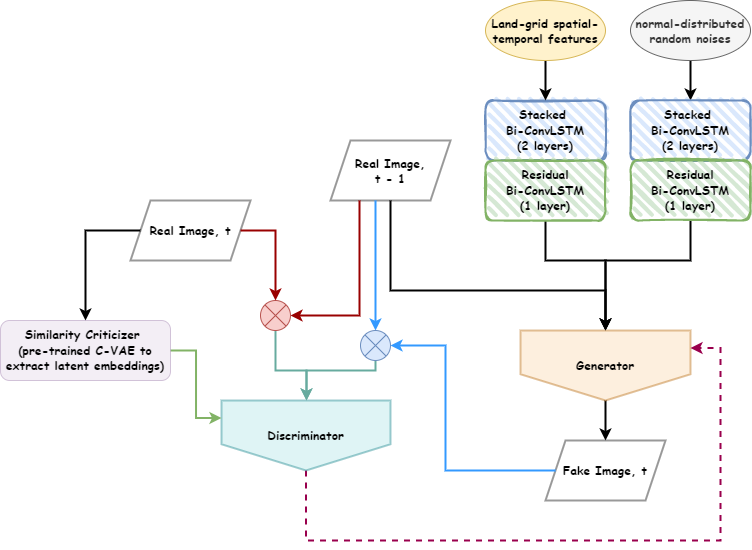

In [2]:
from IPython.display import Image
Image("C:/Users/Model_vis-Page-2.drawio.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

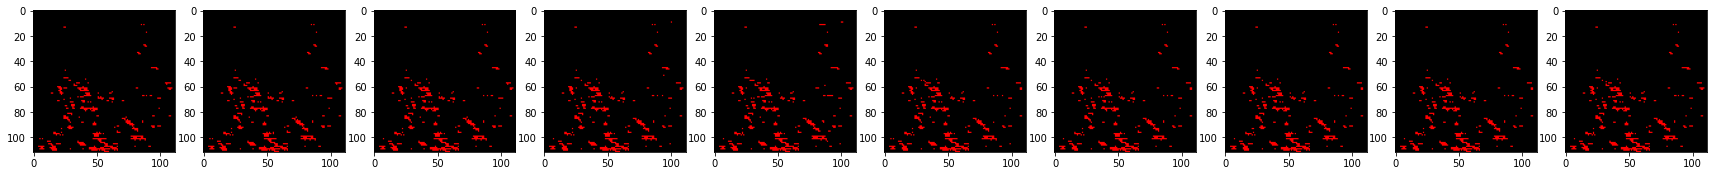

In [ ]:
## without slowing down the learning rate at the commencement of training at 800 epochs:  Mode Collapse
plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

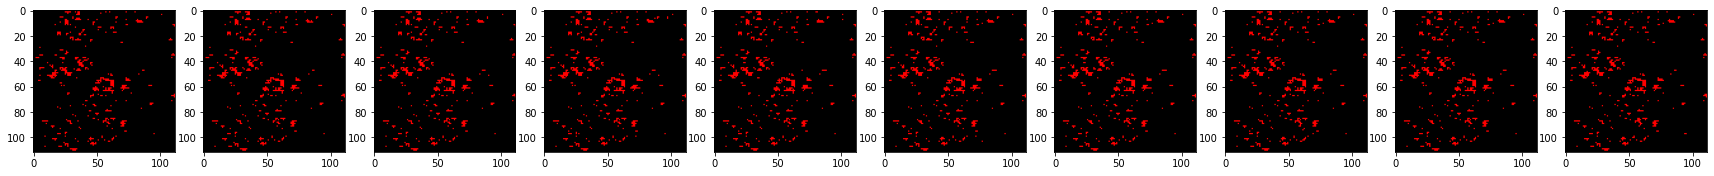

In [ ]:
## without slowing down the learning rate at the commencement of training at 900 epochs:  Mode Collapse
plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

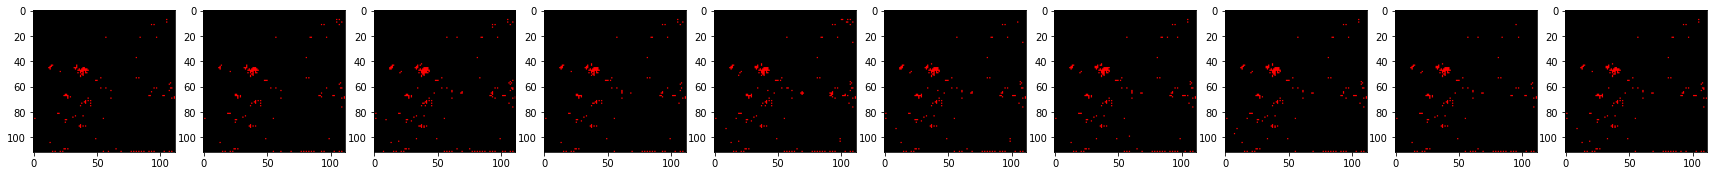

In [ ]:
## without slowing down the learning rate at the commencement of training at 1000 epochs:  Mode Collapse
plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

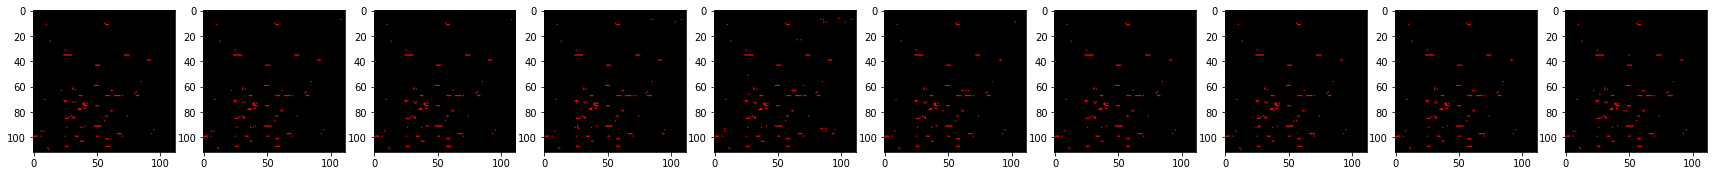

In [ ]:
## without slowing down the learning rate at the commencement of training at 1200 epochs:  Mode Collapse
plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

In [6]:
from conditional_gan.model import (
                                    Generator, 
                                    Discriminator,
                                    Similarity_Criticizer,
                                    ConditionalDCGAN
                                )
from conditional_gan.monitor import GAN_Monitor

In [ ]:
gen_test = Generator()
gen_test.generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.9))

In [ ]:
dis_test = Discriminator()
dis_test.discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.9))

In [ ]:
sim_critic = Similarity_Criticizer(width=112, height=112, depth=1, embedding_dim=384)
sim_critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005))

In [ ]:
## target wildfire maps
grid_targets = np.load(F"/content/drive/MyDrive/DS project/Data Sources/ml_arrays/long_term/land_targets.npz")['arr_0']
tf.config.run_functions_eagerly(True)

In [ ]:
sim_critic.encoder.summary(line_length=150)

Model: "encoder"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_23 (InputLayer)                           [(None, 112, 112, 1)]            0                 []                                                
                                                                                                                                                      
 conv2d_85 (Conv2D)                              (None, 56, 56, 4)                40                ['input_23[0][0]']                                
                                                                                                                                                      
 conv2d_86 (Conv2D)                              (None, 28, 28, 8)           

In [ ]:
sim_critic.decoder.summary(line_length=150)

Model: "decoder"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_24 (InputLayer)                                             [(None, 384)]                                               0                      
                                                                                                                                                      
 dense_43 (Dense)                                                  (None, 392)                                                 150920                 
                                                                                                                                                      
 reshape_2 (Reshape)                                               (None, 7, 

In [ ]:
sim_critic.fit(grid_targets, epochs=10, batch_size=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


27/27 [==============================] - 3s 39ms/step - loss: 0.0149 - reconstruction_loss: 4.9164e-05 - kl_loss: 0.0092
Epoch 2/10
27/27 [==============================] - 1s 41ms/step - loss: 0.0022 - reconstruction_loss: 4.9014e-05 - kl_loss: 0.0016
Epoch 3/10
27/27 [==============================] - 1s 40ms/step - loss: 8.9634e-04 - reconstruction_loss: 4.8876e-05 - kl_loss: 7.1842e-04
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 4.6671e-04 - reconstruction_loss: 4.8742e-05 - kl_loss: 4.0597e-04
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 3.2823e-04 - reconstruction_loss: 4.8611e-05 - kl_loss: 2.4207e-04
Epoch 6/10
27/27 [==============================] - 1s 40ms/step - loss: 1.8805e-04 - reconstruction_loss: 4.8484e-05 - kl_loss: 1.4362e-04
Epoch 7/10
27/27 [==============================] - 1s 40ms/step - loss: 1.4756e-04 - reconstruction_loss: 4.8369e-05 - kl_loss: 8.8094e-05
Epoch 8/10
27/27 [=============================

In [ ]:
## VAE Encoder
intermediate_sim_critic = tf.keras.Model(
    inputs = sim_critic.encoder.input, 
    outputs = sim_critic.encoder.get_layer("dense_42").output
    )

In [ ]:
embeddings = intermediate_sim_critic.predict(grid_targets, batch_size=10)
print(embeddings.shape)

(270, 384)

In [ ]:
## pair-wise cosine distance
sim_embeddings = np.array(1 - cosine_similarity(embeddings, embeddings)).reshape(1,embeddings.shape[0],embeddings.shape[0],1)

In [ ]:
sim_embeddings.shape

(1, 270, 270, 1)

In [ ]:
gen_test.generator.summary(line_length = 150)

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_4 (InputLayer)                            [(None, 6, 50, 50, 250)]         0                 []                                                
                                                                                                                                                      
 zero_padding3d (ZeroPadding3D)                  (None, 6, 56, 56, 250)           0                 ['input_4[0][0]']                                 
                                                                                                                                                      
 bidirectional (Bidirectional)                   (None, 6, 56, 56, 256)      

In [ ]:
dis_test.discriminator.summary(line_length = 150)

Model: "model_2"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_7 (InputLayer)                            [(None, 112, 112, 1)]            0                 []                                                
                                                                                                                                                      
 input_8 (InputLayer)                            [(None, 112, 112, 1)]            0                 []                                                
                                                                                                                                                      
 concatenate_5 (Concatenate)                     (None, 112, 112, 2)         

In [7]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config = config)
tf.config.run_functions_eagerly(True)

In [8]:
## grid-specific land features
grid_features = np.load(F"/content/drive/MyDrive/DS project/Data Sources/ml_arrays/long_term/land_features.npz")['arr_0']
## target wildfire maps
grid_targets = np.load(F"/content/drive/MyDrive/DS project/Data Sources/ml_arrays/long_term/land_targets.npz")['arr_0']
## target wildfire maps at previous state
grid_prev_targets = np.load(F"/content/drive/MyDrive/DS project/Data Sources/ml_arrays/long_term/land_prev_targets.npz")['arr_0']
## global embeddings
sim_embeddings = np.load(F"/content/drive/My Drive/DS project/sim_embeddings.npz")['arr_0']

In [9]:
# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((grid_features, grid_targets, grid_prev_targets))
dataset = dataset.batch(batch_size=2)

In [10]:
## load similarity criticizer
intermediate_sim_critic = tf.keras.models.load_model(F"/content/drive/My Drive/DS project/sim_critic_embeddings.h5")

In [11]:
## model class
batch_per_update = 2
gan = ConditionalDCGAN(batch_size = batch_per_update, 
                       similarity_criticizer = intermediate_sim_critic, 
                       global_sim_embeddings = np.concatenate([[sim_embeddings] * batch_per_update], axis=0).reshape(batch_per_update,270,270,1)
                       )
## compile models
gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=5e-7),
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.data.experimental.enable_debug_mode()

In [ ]:
## first 200 epochs with 
##   generator learning rate = 5e-5
##   discriminator learning rate = 5e-7

gan.fit(dataset, epochs = 200, callbacks=[GAN_Monitor(gan, grid_features, grid_prev_targets, 
                                                      logs=True, log_path=F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/")])

Epoch 1/200
135/135 [==============================] - 257s 2s/step - d_loss: 125.6203 - g_loss: 0.8601 - accuracy: 0.9446 - IOU: 0.0000e+00
Epoch 2/200
135/135 [==============================] - 252s 2s/step - d_loss: 123.8648 - g_loss: 0.8553 - accuracy: 0.9446 - IOU: 0.0000e+00
Epoch 3/200
135/135 [==============================] - 251s 2s/step - d_loss: 124.1822 - g_loss: 0.8433 - accuracy: 0.9446 - IOU: 0.0000e+00
Epoch 4/200
135/135 [==============================] - 251s 2s/step - d_loss: 127.1037 - g_loss: 0.8382 - accuracy: 0.9446 - IOU: 0.0000e+00
Epoch 5/200
135/135 [==============================] - 251s 2s/step - d_loss: 130.5672 - g_loss: 0.8138 - accuracy: 0.9446 - IOU: 0.0000e+00
Epoch 6/200
135/135 [==============================] - 251s 2s/step - d_loss: 141.7587 - g_loss: 0.7909 - accuracy: 0.9446 - IOU: 0.0000e+00
Epoch 7/200
135/135 [==============================] - 250s 2s/step - d_loss: 140.5157 - g_loss: 0.7778 - accuracy: 0.9445 - IOU: 4.6224e-05
Epoch 8/200
1

In [ ]:
gan.generator = tf.keras.models.load_model(F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/fire_monthly/epoch_200_generator.h5")
gan.discriminator = tf.keras.models.load_model(F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/fire_monthly/epoch_200_discriminator.h5")

In [ ]:
## 200 epochs to 250 epochs with 
##   generator learning rate = 5e-5
##   discriminator learning rate = 5e-6

gan.fit(dataset, epochs = 50, callbacks=[GAN_Monitor(gan, grid_features, grid_prev_targets, 
                                                      logs=True, log_path=F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/")])

Epoch 1/50
135/135 [==============================] - 290s 2s/step - d_loss: 101.5587 - g_loss: 0.4487 - accuracy: 0.9496 - IOU: 0.2433
Epoch 2/50
135/135 [==============================] - 286s 2s/step - d_loss: 136.9426 - g_loss: 0.4489 - accuracy: 0.9496 - IOU: 0.2421
Epoch 3/50
135/135 [==============================] - 286s 2s/step - d_loss: 120.7661 - g_loss: 0.4479 - accuracy: 0.9498 - IOU: 0.2444
Epoch 4/50
135/135 [==============================] - 286s 2s/step - d_loss: 113.1799 - g_loss: 0.4439 - accuracy: 0.9499 - IOU: 0.2450
Epoch 5/50
135/135 [==============================] - 285s 2s/step - d_loss: 105.7894 - g_loss: 0.4441 - accuracy: 0.9501 - IOU: 0.2494
Epoch 6/50
135/135 [==============================] - 285s 2s/step - d_loss: 100.7704 - g_loss: 0.4433 - accuracy: 0.9502 - IOU: 0.2476
Epoch 7/50
135/135 [==============================] - 285s 2s/step - d_loss: 85.6892 - g_loss: 0.4444 - accuracy: 0.9501 - IOU: 0.2454
Epoch 8/50
135/135 [=============================

In [ ]:
gan.generator = tf.keras.models.load_model(F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/fire_monthly/epoch_250_generator.h5")
gan.discriminator = tf.keras.models.load_model(F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/fire_monthly/epoch_250_discriminator.h5")

In [ ]:
## 250 epochs to 300 epochs with 
##   generator learning rate = 5e-5
##   discriminator learning rate = 5e-6

gan.fit(dataset, epochs = 50, callbacks=[GAN_Monitor(gan, grid_features, grid_prev_targets, 
                                                      logs=True, log_path=F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/")])

Epoch 1/50
135/135 [==============================] - 251s 2s/step - d_loss: 44.3409 - g_loss: 0.3916 - accuracy: 0.9547 - IOU: 0.3033
Epoch 2/50
135/135 [==============================] - 248s 2s/step - d_loss: 4.2146 - g_loss: 0.3898 - accuracy: 0.9549 - IOU: 0.3068
Epoch 3/50
135/135 [==============================] - 246s 2s/step - d_loss: 2.8351 - g_loss: 0.3920 - accuracy: 0.9548 - IOU: 0.3046
Epoch 4/50
135/135 [==============================] - 247s 2s/step - d_loss: 3.1768 - g_loss: 0.3904 - accuracy: 0.9549 - IOU: 0.3076
Epoch 5/50
135/135 [==============================] - 246s 2s/step - d_loss: 2.1914 - g_loss: 0.3908 - accuracy: 0.9550 - IOU: 0.3087
Epoch 6/50
135/135 [==============================] - 246s 2s/step - d_loss: 2.4767 - g_loss: 0.3893 - accuracy: 0.9550 - IOU: 0.3101
Epoch 7/50
135/135 [==============================] - 247s 2s/step - d_loss: 2.2098 - g_loss: 0.3866 - accuracy: 0.9551 - IOU: 0.3069
Epoch 8/50
135/135 [==============================] - 247s 2s

In [ ]:
gan.generator = tf.keras.models.load_model(F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/fire_monthly/epoch_300_generator.h5")
gan.discriminator = tf.keras.models.load_model(F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/fire_monthly/epoch_300_discriminator.h5")

In [ ]:
## 300 epochs to 350 epochs with 
##   generator learning rate = 5e-5
##   discriminator learning rate = 1e-5

gan.fit(dataset, epochs = 50, callbacks=[GAN_Monitor(gan, grid_features, grid_prev_targets, 
                                                      logs=True, log_path=F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/")])

Epoch 1/50
135/135 [==============================] - 256s 2s/step - d_loss: 30.0440 - g_loss: 0.3524 - accuracy: 0.9583 - IOU: 0.3539
Epoch 2/50
135/135 [==============================] - 254s 2s/step - d_loss: 0.2357 - g_loss: 0.3573 - accuracy: 0.9582 - IOU: 0.3520
Epoch 3/50
135/135 [==============================] - 257s 2s/step - d_loss: 0.1684 - g_loss: 0.3555 - accuracy: 0.9585 - IOU: 0.3544
Epoch 4/50
135/135 [==============================] - 258s 2s/step - d_loss: 0.2074 - g_loss: 0.3549 - accuracy: 0.9583 - IOU: 0.3545
Epoch 5/50
135/135 [==============================] - 258s 2s/step - d_loss: 0.1894 - g_loss: 0.3547 - accuracy: 0.9585 - IOU: 0.3561
Epoch 6/50
135/135 [==============================] - 259s 2s/step - d_loss: 0.1136 - g_loss: 0.3533 - accuracy: 0.9587 - IOU: 0.3579
Epoch 7/50
135/135 [==============================] - 258s 2s/step - d_loss: 0.1119 - g_loss: 0.3502 - accuracy: 0.9590 - IOU: 0.3609
Epoch 8/50
135/135 [==============================] - 257s 2s

In [15]:
## 300 epochs to 350 epochs with 
##   generator learning rate = 5e-5
##   discriminator learning rate = 5e-5

gan.fit(dataset, epochs = 50, callbacks=[GAN_Monitor(gan, grid_features, grid_prev_targets, 
                                                      logs=True, log_path=F"/content/drive/My Drive/DS project/example_models/condcgan/checkpoints/")])

Epoch 1/50
135/135 [==============================] - 299s 2s/step - d_loss: 19.9765 - g_loss: 0.3240 - accuracy: 0.9615 - IOU: 0.3961
Epoch 2/50
135/135 [==============================] - 290s 2s/step - d_loss: 0.0340 - g_loss: 0.3285 - accuracy: 0.9616 - IOU: 0.3961
Epoch 3/50
135/135 [==============================] - 289s 2s/step - d_loss: 0.0193 - g_loss: 0.3284 - accuracy: 0.9617 - IOU: 0.3997
Epoch 4/50
135/135 [==============================] - 290s 2s/step - d_loss: 0.0109 - g_loss: 0.3292 - accuracy: 0.9618 - IOU: 0.3996
Epoch 5/50
135/135 [==============================] - 286s 2s/step - d_loss: 0.0231 - g_loss: 0.3286 - accuracy: 0.9619 - IOU: 0.4005
Epoch 6/50
135/135 [==============================] - 285s 2s/step - d_loss: 0.0130 - g_loss: 0.3288 - accuracy: 0.9618 - IOU: 0.3979
Epoch 7/50
135/135 [==============================] - 285s 2s/step - d_loss: 0.0277 - g_loss: 0.3296 - accuracy: 0.9618 - IOU: 0.3952
Epoch 8/50
135/135 [==============================] - 285s 2s

#### **Results:**

With the above progressive training scheme, after 100 epochs, the 10 sampled images generated were starting to distinguish the general patterns such that the months with most activities of wildfires had more red-colored pixels recognized, though a relatively error was observed in the 1st, 5th, 6th, 7th, 9th and 10th iamges. The Jaccard Index (intersection-over-union, IOU score) achieved was only aorund 0.13 at this stage.

Then a great improvement was seen after training for 200 epochs, especially on the 5th and 6th images. The IOU score boosted to around 0.29 and the acuuracy approched nearly 95%. After 300 epochs, the quality of the generated images kept re-fining, and the previous mode collapse problem did not appear. After 400 epochs, the IOU score increased to over 0.46 and the accuracy was over 96.5% which was already a pleasant score in some of the past literature for wildfire forecasting (IOU score around 0.50 checking the case in the following reference).

(Huot, F., Hu, R. L., Ihme, M., Wang, Q., Burge, J., Lu, T., Hickey, J., Chen, YF., & Anderson, J. (2020). Deep Learning Models for Predicting Wildfires from Historical Remote-Sensing Data. <i>Presented at 34th Conference on Neural Information Processing Systems (NeurIPS 2020), Artificial Intelligence for Humani- tarian Assistance and Disaster Response Workshop, Vancouver, Canada. Available from arXiv:2010.07445.</i>)

<br>

In [29]:
out = []
for i in range(0, len(grid_features), 2):
    random_latent_vectors = tf.random.normal([2, 6, 56, 56, 50])
    generated_images = gan.generator([random_latent_vectors, 
                                      grid_features[i:(i+2)].reshape(2, 6, 50, 50, 50*5), 
                                      grid_prev_targets[i:(i+2)].reshape(2, 112, 112, 1)], training=False)
    out.append(generated_images)

In [30]:
out = np.concatenate(out)

In [15]:
## 100 epochs
print(accuracy_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))
print(jaccard_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))

0.921109693877551
0.12855218569699975


In [25]:
## 200 epochs
print(accuracy_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))
print(jaccard_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))

0.9496282714474679
0.2919480217641224


In [31]:
## 300 epochs
print(accuracy_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))
print(jaccard_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))

0.9601234764739229
0.39041046426604803


In [ ]:
## 350 epochs
print(accuracy_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))
print(jaccard_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))

0.9607255054799697
0.36001655071543354


In [18]:
## 400 epochs
print(accuracy_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))
print(jaccard_score(out.astype(int).reshape(-1, 1), grid_targets.reshape(-1, 1)))

0.9662181712962963
0.4655602473795333


In [17]:
import cv2
from google.colab.patches import cv2_imshow

In [18]:
actual_list = []
for n in range(len(grid_targets)):
    i = grid_targets[n]
    t = np.zeros((112,112,3))
    for r in range(112):
        for c in range(112):
            if np.sum(i[r,c,:]) > 0:
                t[r,c,:] = np.array([255,0,0])
            else:
                t[r,c,:] = np.array([0,0,0])
    actual_list.append(t)

In [32]:
gen_list = []
for n in range(len(out.astype(int))):
    j = out.astype(int)[n]
    t = np.zeros((112,112,3))
    for r in range(112):
        for c in range(112):
            if np.sum(j[r,c,:]) > 0:
                t[r,c,:] = np.array([255,0,0])
            else:
                t[r,c,:] = np.array([0,0,0])
    gen_list.append(t)

In [20]:
import random
rand_idx = random.sample(range(270), 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

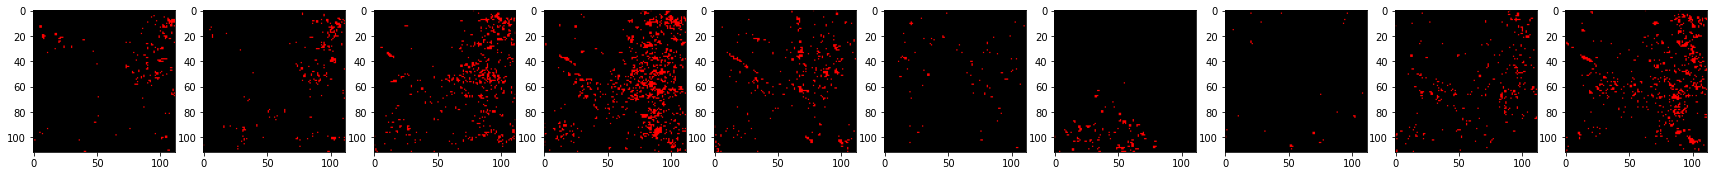

In [ ]:
## True images

plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(actual_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

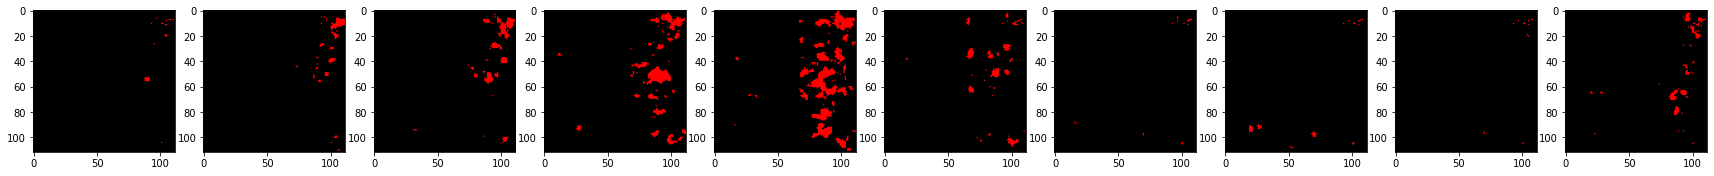

In [22]:
## after 100 epochs

plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

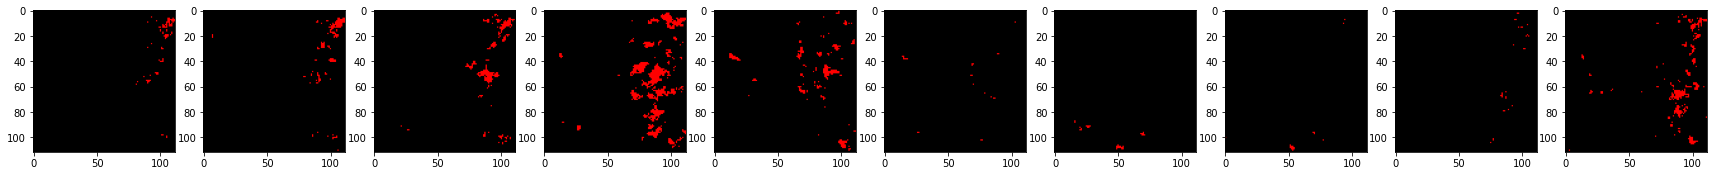

In [27]:
## after 200 epochs

plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

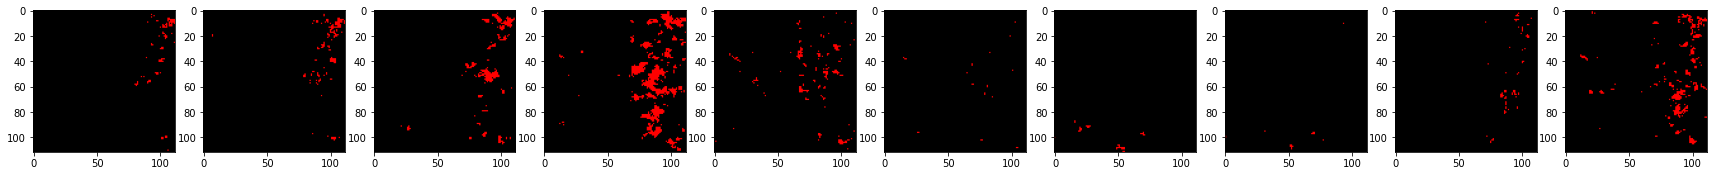

In [33]:
## after 300 epochs

plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

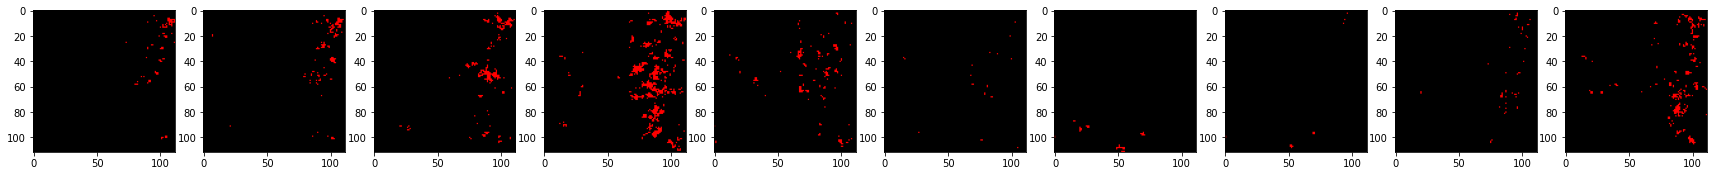

In [ ]:
## after 350 epochs

plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

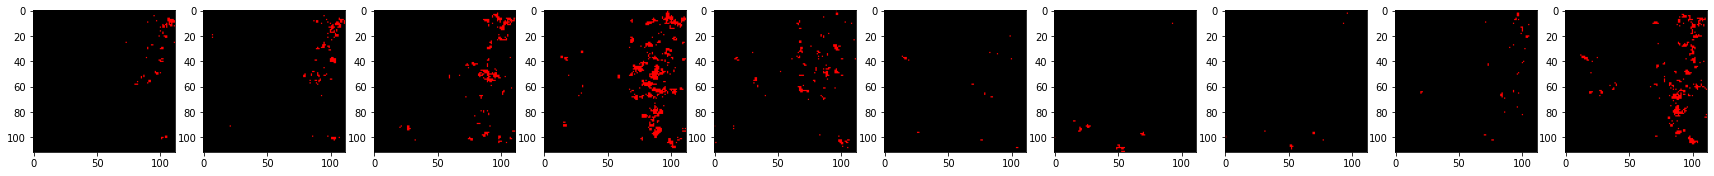

In [23]:
## after 400 epochs

plt.rcParams["figure.figsize"] = (30,5)
f, ax = plt.subplots(ncols=10, nrows=1)
for k in range(len(rand_idx)):
  ax[k].imshow(gen_list[k])